# Deep Ritz Method

## Introduction of Example 1

Using the Deep Ritz Method to solve the following PDE problem

$$
-\Delta u(x) = 1, x\in \Omega, \\
u(x) = 0, x\in \partial \Omega  \\
\Omega = (-1,1) * (-1,1) \ [0,1) *{0}
$$

> Note:   
> This code is from [xdfeng7370](https://github.com/xdfeng7370/Deep-Ritz-Method), some contents have been modified.

## 1. Import modules and libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, autograd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## 2. Define functions and Deep Ritz Network

In [2]:
class PowerReLU(nn.Module):
    """
    Implements simga(x)^(power)
    Applies a power of the rectified linear unit element-wise.

    NOTE: inplace may not be working.
    Can set inplace for inplace operation if desired.
    BUT I don't think it is working now.

    INPUT:
        x -- size (N, *) tensor where * is any number of additional dimensions
    OUTPUT:
        y -- size (N, *)
    """

    def __init__(self, inplace=False, power=3):
        super(PowerReLU, self).__init__()
        self.inplace = inplace
        self.power = power

    def forward(self, input):
        y = F.relu(input, inplace=self.inplace)
        return torch.pow(y, self.power)


class Block(nn.Module):
    """
    Implementation of the block used in the Deep Ritz Paper,
    it contains two fully-connected layers, activation function, and
    a residual connection.

    Parameters:
        in_N  -- dimension of the input
        width -- number of nodes in the interior middle layer
        out_N -- dimension of the output
        phi   -- activation function used
    """

    def __init__(self, in_N, width, out_N, phi=PowerReLU()):
        super(Block, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        self.phi = nn.Tanh()

    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x


class drrnn(nn.Module):
    """
    drrnn -- Deep Ritz Residual Neural Network

    Implements a network with the architecture used in the deep ritz method paper

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=4, phi=PowerReLU()):
        super(drrnn, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        self.phi = nn.Tanh()
        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(Block(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

Then, we randomly sample training points

In [3]:
def get_interior_points(N=128, d=2):
    """
    randomly sample N points from interior of [-1,1]^d
    """
    return torch.rand(N, d) * 2 - 1


def get_boundary_points(N=33):
    """
    randomly sample points from boundaries
    """
    index = torch.rand(N, 1)
    index1 = torch.rand(N, 1) * 2 - 1

    xb1 = torch.cat((index, torch.zeros_like(index)), dim=1) # BC on [0, 1]×{0}
    xb2 = torch.cat((index1, torch.ones_like(index1)), dim=1) # BC on top, [-1, 1]×{1}
    xb3 = torch.cat((index1, torch.full_like(index1, -1)), dim=1) # BC on bottom, [-1, 1]×{-1}
    xb4 = torch.cat((torch.ones_like(index1), index1), dim=1) # BC on right, {1}×[-1, 1]
    xb5 = torch.cat((torch.full_like(index1, -1), index1), dim=1) # BC on left, {-1}×[-1, 1]

    xb = torch.cat((xb1, xb2, xb3, xb4, xb5), dim=0)

    return xb

In [4]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight) # Initialize the weight Tensor with values using a Xavier normal distribution.
        nn.init.constant_(m.bias, 0.0) # Fill the bias Tensor with 0.0


def train():

    epochs = 50000

    in_N = 2
    m = 10
    out_N = 1

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = drrnn(in_N, m, out_N).to(device)
    model.apply(init_weights)

    criteon = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=3e-3)

    # x = torch.cat((xr, xb), dim=0)

    # if 2 < m:
    #     y = torch.zeros(x.shape[0], m - 2)
    #     x = torch.cat((x, y), dim=1)
    # # print(x.shape)
    best_loss, best_epoch = 1000, 0
    for epoch in range(epochs+1):

        # generate the data set
        xr = get_interior_points().to(device)
        xr.requires_grad_() # we need to calculate the derivatives of xr, so we set required_grad = True
        xb = get_boundary_points().to(device)

        output_r = model(xr) # u(xr)
        output_b = model(xb) # u(xb)
        grads = autograd.grad(outputs=output_r, inputs=xr, # d(u(xr)) / d(xr)
                              grad_outputs=torch.ones_like(output_r),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

        # calculate the loss value. details can be found in equation (3.2)
        loss_r = 0.5 * torch.sum(torch.pow(grads, 2), dim=1) - output_r
        loss_r = torch.mean(loss_r)
        loss_b = torch.mean(torch.pow(output_b, 2))
        loss = 4 * loss_r + 9 * 500 * loss_b

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print('epoch:', epoch, 'loss:', loss.item(), 'loss_r:', (4 * loss_r).item(), 'loss_b:', (9*500 * loss_b).item())
            if epoch > int(4 * epochs / 5):
                if torch.abs(loss) < best_loss:
                    best_loss = torch.abs(loss).item()
                    best_epoch = epoch
                    torch.save(model.state_dict(), 'assets/weights/deep_ritz_example1_best.mdl')
    print('best epoch:', best_epoch, 'best loss:', best_loss)


In [5]:
train()

d:\Software\Anaconda3\envs\ai4s\Lib\site-packages\torch\autograd\graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch: 0 loss: 2899.046142578125 loss_r: 2.330592393875122 loss_b: 2896.715576171875
epoch: 100 loss: 0.5394586324691772 loss_r: 0.053480908274650574 loss_b: 0.4859777092933655
epoch: 200 loss: 0.4075932800769806 loss_r: 0.033567216247320175 loss_b: 0.3740260601043701
epoch: 300 loss: 0.2649858891963959 loss_r: 0.017147012054920197 loss_b: 0.24783888459205627
epoch: 400 loss: 0.16355901956558228 loss_r: 0.017982441931962967 loss_b: 0.1455765813589096
epoch: 500 loss: 0.13145838677883148 loss_r: -0.02550196647644043 loss_b: 0.1569603532552719
epoch: 600 loss: 0.10052281618118286 loss_r: -0.021130315959453583 loss_b: 0.12165313214063644
epoch: 700 loss: 0.0795476958155632 loss_r: -0.03039996325969696 loss_b: 0.10994765907526016
epoch: 800 loss: 0.06796561181545258 loss_r: -0.04035584628582001 loss_b: 0.10832145810127258
epoch: 900 loss: 0.01925213262438774 loss_r: -0.04860718175768852 loss_b: 0.06785931438207626
epoch: 1000 loss: 0.050053421407938004 loss_r: -0.044160548597574234 loss_b:

C:\Users\43757\AppData\Local\Temp\ipykernel_492\515558707.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('assets/weights/deep_ritz_exa

load weights from ckpt!


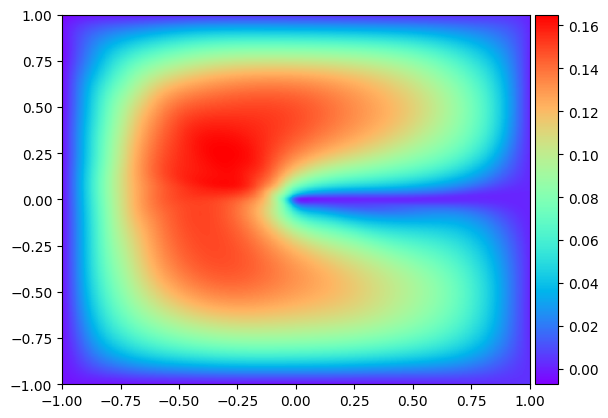

In [6]:
# plot figure
in_N = 2
m = 10
out_N = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = drrnn(in_N, m, out_N).to(device)

model.load_state_dict(torch.load('assets/weights/deep_ritz_example1_best.mdl'))
print('load weights from ckpt!')

with torch.no_grad():
    x1 = torch.linspace(-1, 1, 1001)
    x2 = torch.linspace(-1, 1, 1001)
    X, Y = torch.meshgrid(x1, x2)
    Z = torch.cat((Y.flatten()[:, None], Y.T.flatten()[:, None]), dim=1)
    # if 2 < m:
    #     y = torch.zeros(Z.shape[0], m - 2)
    #     Z = torch.cat((Z, y), dim=1)
    Z = Z.to(device)
    pred = model(Z)

plt.figure()
pred = pred.cpu().numpy()
pred = pred.reshape(1001, 1001)
ax = plt.subplot(1, 1, 1)
h = plt.imshow(pred, interpolation='nearest', cmap='rainbow',
                extent=[-1, 1, -1, 1],
                origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
plt.show()